# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignment (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`01` 

* Catherine Prokhorov (62608) - `4` Hours worked on the project
* Guilherme Cepeda (62931) - `3` Hours worked on the project
* Jorge Aleluia (54549) - `3` Hours worked on the project 
* Rómulo Nogueira (56935) - `4` Hours worked on the project


The purpose of this Home Assignment is:

- Find similar items with Local Sensitivity Hashing
- Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**

### 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic


Students can use one of two datasets, that are not subsets of each other:
- `data_d3.pickle` - smaller set of structural features (2048)
- `data_d4.pickle` - much larger set of structural features (20736) **Note**: This dataset has been Zipped to fit into moodle. Students should unzip it before usage

Select **one** of the datasets and perform all analyses with it.

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [1]:
### Your code here
import pickle
import sys
from scipy.sparse import dok_array, csr_array, csc_array, bsr_array, lil_array
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

f = open("data_d4.pickle", "rb")

# Load the data
with open("data_d4.pickle", "rb") as f:
    data = pickle.load(f)

proteins_ids = list(data.keys())
set_characteristics = list(data.values())
max_characteristics = max([max(x) for x in set_characteristics])
len_characteristics = max_characteristics + 1

print("We have a total of {} human proteins".format(len(proteins_ids)))
print("And a total of {} specific structural characteristics".format(len_characteristics))
print("This would result in a matrix of size {}x{}".format(len(proteins_ids), len_characteristics))

def make_sparse_matrix(set_characteristics: list[set], proteins_ids: list, len_characteristics: int):
    N = len(proteins_ids)
    M = len_characteristics

    S_Mat = dok_array((N, M), dtype=np.int8)
    for i in range(N):
        characteristics_idxs = list(set_characteristics[i])
        S_Mat[i, characteristics_idxs] = 1

    return S_Mat

dok_matrix = make_sparse_matrix(set_characteristics, proteins_ids, len_characteristics)
csr_matrix = csr_array(dok_matrix)
csr_matrix_pickle = pickle.dumps(csr_matrix)

print("CSR matrix size (in MB): ", sys.getsizeof(csr_matrix_pickle)/(1024*1024))

We have a total of 19258 human proteins
And a total of 20736 specific structural characteristics
This would result in a matrix of size 19258x20736
CSR matrix size (in MB):  115.15146827697754


### 2. Perform Local Sensitivity Hashing (LSH)

- examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
- Comment your results

**BONUS POINTS**: It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [2]:
### Add support functions here

def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()

def MakeBucketsT(TDocs, perms, N, M, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i==M:                              #this is the case that the document is empty 
                    SIGS[list(L), r]=i                # Highly unlikely in a real data set  
                    L={}
                                                      # we have completed the signature for a given band, 
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N,M=Data.shape
    #transpose the data set
    DT=Data.T
    DataT=[set(np.where(DT[i]==1)[0]) for i in range(M)]
    P=B*R
    np.random.seed(3)
    #print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms=[np.random.permutation(M) for i in range(P)]
    buckets=MakeBucketsT(DataT, perms, N, M, B,R, NB)
    return buckets

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc

The probability that proteins share at least one band signature if they are 0.95 similar is:  1.0000
Which means that the we have 0.00 probabilty that documents with 0.95 similarity will not be found


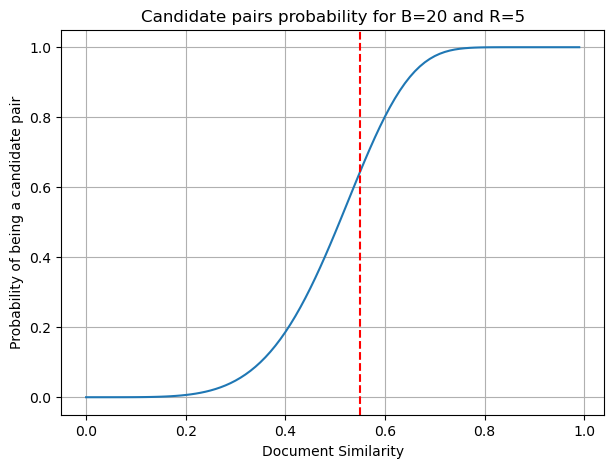

There are a total of 9 pairs of proteins with a Jaccard similarity greater than 0.75

The following pairs were identified by:
Band  5 Bucket 27287098
Band  6 Bucket 15252554
Band  7 Bucket 44020
Band  8 Bucket 24333270
Band 11 Bucket 2657780
Band 12 Bucket 1128311
Band 13 Bucket 6972902
Band 14 Bucket 16895273
Band 19 Bucket 10246347
Jaccard Similarity between protein 5402 and 10565 is:  0.8767

The following pairs were identified by:
Band  0 Bucket 28206037
Band  2 Bucket 24223007
Band  3 Bucket 14439439
Band  4 Bucket 16509583
Band  5 Bucket 14111463
Band  6 Bucket 21978625
Band 11 Bucket 16933387
Band 14 Bucket 19105427
Band 17 Bucket 6055414
Jaccard Similarity between protein 15858 and 16582 is:  0.8727

The following pairs were identified by:
Band  0 Bucket 18990451
Band  3 Bucket 21011818
Band  4 Bucket 28196119
Band  5 Bucket 27287098
Band  7 Bucket 44020
Band  8 Bucket 24333270
Band  9 Bucket 13042015
Band 11 Bucket 2657780
Band 12 Bucket 1128311
Band 13 Bucket 6972902
Band 14 

In [3]:
### Add processing code here

B = 20
R = 5

s = 0.95

P = 1-(1-s**R)**B
print("The probability that proteins share at least one band signature if they are %4.2f similar is: %7.4f" %(s, P))
print("Which means that the we have %4.2f probabilty that documents with %4.2f similarity will not be found" %(1-P, s))

DrawSimPlot(B,R)

dense_matrix = csr_matrix.toarray()
bucks = LSHT(dense_matrix, B, R)

data = []
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        doc_ids=np.array(list(bucks[(b,buck)]))
        idx = np.stack(np.triu_indices(len(doc_ids), k=1), axis=-1)
        sim_pairs=doc_ids[idx]
        for d1, d2 in sim_pairs:
            J=JaccardSim(dense_matrix[d1], dense_matrix[d2])
            if J>0.75: 
                data.append({
                    "b,buck": (b, buck),
                    "d1": d1,
                    "d2": d2,
                    "J": J
                })

data = sorted(data, key=lambda x: x["J"], reverse=True)

grouped_data = defaultdict(lambda: {'b,buck': [], 'd1': None, 'd2': None, 'J': None})

for entry in data:
    key = (entry['d1'], entry['d2'])
    grouped_data[key]['b,buck'].append(entry['b,buck'])
    grouped_data[key]['d1'] = entry['d1']
    grouped_data[key]['d2'] = entry['d2']
    grouped_data[key]['J'] = entry['J']

result = list(grouped_data.values())

print("There are a total of %d pairs of proteins with a Jaccard similarity greater than 0.75" % len(result))
print()

for group in result:
    print("The following pairs were identified by:")
    for b,buck in group['b,buck']:
        print("Band %2d Bucket %2d" % (b, buck))
    print ("Jaccard Similarity between protein %d and %d is: %7.4f" %(group['d1'],group['d2'],group['J']))
    print()


##### Your short analysis here

In our analysis, after dividing the output space into buckets, we used `LSH (Locality-Sensitive Hashing) and Jaccard similarity` to identify *highly similar protein pairs*. The probability graph for candidate pairs, with parameters *B = 20 and R = 5*, clearly indicates that the probability of identifying pairs with a similarity of 0.95 is 1.0. This means our model is **highly effective at detecting pairs with high similarity**. Additionally, the graph shows that there is virtually no chance of missing documents with 0.95 similarity, ensuring robust detection for highly similar pairs.

We identified nine pairs of proteins with Jaccard similarity greater than 0.75, utilizing various bands and buckets. This indicates the distribution of similar pairs across multiple hash functions. For instance, protein pairs 5402 and 10565 have a similarity score of 0.8767, and proteins 15858 and 16582 have a similarity score of 0.8727.

The chosen parameters allowed us to effectively capture highly similar protein pairs, and the **Jaccard similarity metric proves to be reliable**. The overall approach shows strong potential for identifying similar proteins in a high-dimensional space like the human protein space.


### 3. Do dimensionality reduction

Use the techniques discussed in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information

In [25]:
### Add support functions here
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Dimensionality reduction using PCA
X = csr_matrix.toarray() 
y = np.array(proteins_ids)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

pca = PCA(n_components=70)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Map protein IDs to integers
protein_id_to_int = {protein_id: idx for idx, protein_id in enumerate(np.unique(proteins_ids))}
y_train_int = np.array([protein_id_to_int[pid] for pid in y_train])
y_test_int = np.array([protein_id_to_int[pid] for pid in y_test])

PC0 - Variance explained:  0.0806 - Total Variance:  0.0806
PC1 - Variance explained:  0.0108 - Total Variance:  0.0913
PC2 - Variance explained:  0.0078 - Total Variance:  0.0991
PC3 - Variance explained:  0.0064 - Total Variance:  0.1056
PC4 - Variance explained:  0.0045 - Total Variance:  0.1101
PC5 - Variance explained:  0.0040 - Total Variance:  0.1141
PC6 - Variance explained:  0.0036 - Total Variance:  0.1177
PC7 - Variance explained:  0.0031 - Total Variance:  0.1208
PC8 - Variance explained:  0.0028 - Total Variance:  0.1236
PC9 - Variance explained:  0.0023 - Total Variance:  0.1259
PC10 - Variance explained:  0.0021 - Total Variance:  0.1280
PC11 - Variance explained:  0.0017 - Total Variance:  0.1298
PC12 - Variance explained:  0.0017 - Total Variance:  0.1315
PC13 - Variance explained:  0.0016 - Total Variance:  0.1331
PC14 - Variance explained:  0.0014 - Total Variance:  0.1345
PC15 - Variance explained:  0.0013 - Total Variance:  0.1358
PC16 - Variance explained:  0.0013

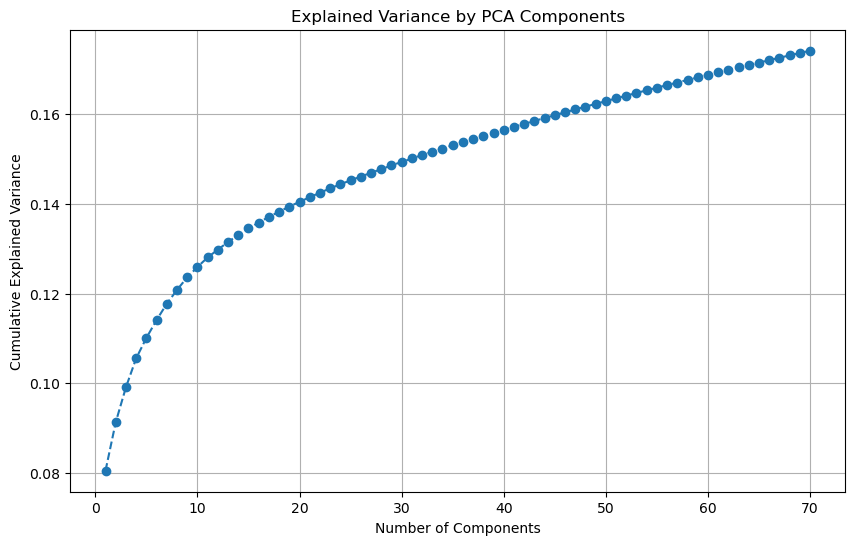

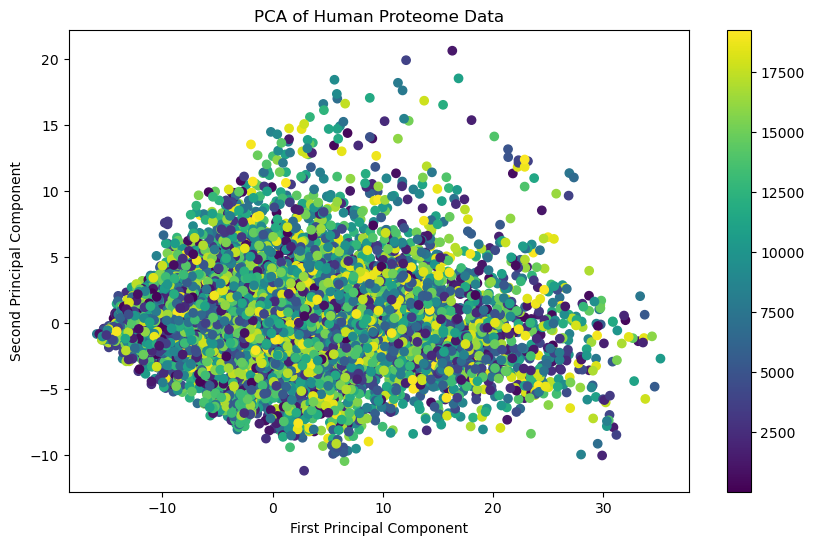

In [26]:
### Add processing code here

tve = 0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve += ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve))

print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, 71), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_int, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Human Proteome Data')
plt.colorbar(scatter)
plt.show()

##### Your short analysis here

**Principal Component Analysis (PCA)** was used to reduce the dimensionality of a dataset by examining the variance explained by each principal component. 

The dataset was divided into training and test sets, with *70 components* specified. The study found that the first 70 principal components explained *17.41% of the variance*. 

The largest eigenvalue was **1004.52**, indicating the first principal component. The subsequent eigenvalues **drop significantly, indicating that the first few components capture most of the variance**. The eigenvalues of the first few components captured most of the variance. 

PCA successfully reduced the dataset's dimensionality, but the explained variance suggests that `more than 70 components` may be needed to retain most of the data's information.

### 3. Discuss your findings [to fill on your own]

- Comment your results above
- Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)

### Applying PCA and LSH to the Full Uniprot Database

For our home assignment, we were provided with datasets to apply **Principal Component Analysis (PCA) and Local Sensitivity Hashing (LSH)**. Here, we discuss how these techniques could be extended to the full Uniprot database, which contains about 248 million proteins.

In our HA, we used **PCA to reduce the dimensionality of our given dataset** (`data_d4.pickle`). PCA is particularly effective for handling large datasets like *Uniprot* because it simplifies the data by reducing the number of variables while retaining essential information. This makes the data more manageable and less computationally intensive. Given the massive size of the *Uniprot database*, PCA would need to retain `more components than the 70 we used in our study to capture a significant portion of the variance`. Visualizing the data in two or three dimensions can help identify clusters of proteins with similar characteristics, aiding in the discovery of new protein families and functional annotations.

Reducing the dimensionality of the dataset with PCA also enhances the performance of other machine learning algorithms. It focuses on the most informative features, leading to better model performance and faster training times. Additionally, PCA helps eliminate noise from the data, ensuring that subsequent analyses are more robust and accurate. This makes the *Uniprot database* more manageable and accessible, facilitating faster and more accurate data retrieval and analysis. **By reducing the data complexity, *PCA can significantly speed up research processes***, enabling the development and testing of hypotheses more efficiently.

We also applied **Local Sensitivity Hashing (LSH) and Jaccard similarity to efficiently manage and query large-scale data**. LSH is ideal for a massive dataset like the *Uniprot database* because it quickly identifies similar proteins sequences without requiring exhaustive comparisons. The parameters we used (B=20, R=5) worked well for our given dataset, `but they would need to be optimized/fine-tuned for Uniprot's vast dataset`. Adjusting the number of bands and rows per band will help balance precision and recall when identifying similar proteins sequences.

In summary, **combining PCA and LSH makes the Uniprot database more manageable, accessible and accurate**, enabling efficient and scalable analysis and retrieval of protein sequences. `PCA reduces the dataset's dimensionality`, while `LSH efficiently queries the data and speeds up the search process`. While both PCA and LSH are approximate methods, their combined use provides a balance between computational efficiency and accuracy in identifying similar protein sequences, enabling the development and testing of hypotheses faster. This combination can lead to significant breakthroughs in understanding protein structure, function, and interactions.